## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


In [2]:
# Ignore the warnings
warnings.simplefilter('ignore')

## Load training and prediction window data from saved sql databases

In [3]:
engine =create_engine('sqlite:///Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [4]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2022-11-14,2.330,-0.04,Montana,44.863002,-111.066538,8.136045,7.856000,7.352857,0.683636,0.550667,0.505714,0
1,2022-11-14,1.490,0.38,Montana,44.863002,-111.066538,8.029227,7.395333,7.257143,0.639091,0.574667,0.570000,0
2,2022-11-14,1.790,0.36,Montana,44.863002,-111.066538,7.628182,7.010667,5.820000,0.523636,0.592667,0.470000,0
3,2022-11-16,15.830,0.58,Montana,44.863002,-111.066538,7.608182,7.502667,6.774286,0.547727,0.595333,0.522857,0
4,2022-11-16,11.888,3.70,Montana,44.863002,-111.066538,7.921273,7.773200,8.495429,0.656818,0.827333,1.004286,0


In [5]:
engine =create_engine('sqlite:///Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [6]:
# Live data to be predicted on after being trained of rolling period for next 7 days. 
#Hence NaN outcome that has to be predicted

df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2022-11-21,2.040,0.01,Montana,44.863002,-111.066538,7.420818,7.064533,6.665714,0.700909,0.691333,0.430000,NaN
1,2022-11-22,1.710,0.50,Montana,44.863002,-111.066538,7.124000,7.189200,6.535714,0.711364,0.702667,0.388571,NaN
2,2022-11-24,8.210,0.01,Montana,44.863002,-111.066538,6.976273,6.922533,5.767143,0.630000,0.640000,0.292857,NaN
3,2022-11-25,15.941,2.60,Montana,44.863002,-111.066538,7.420409,7.056600,6.617286,0.674545,0.740000,0.598571,NaN
4,2022-11-26,4.760,0.82,Montana,44.863002,-111.066538,7.261318,7.218600,6.174429,0.704545,0.797333,0.657143,NaN


**Training is done by considering 22,15 & 7 days window past features rolling average and outcome data is shifted to next 7 Days.**

In [7]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)

In [8]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

## Machine Learning & Boosting algorithms

### Decision Tree with Ada Boost Classifier

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [10]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [11]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [12]:
pred_ABC=grid_search_ABC.predict(X_test)

0.784166822168315
AUC: 0.7842


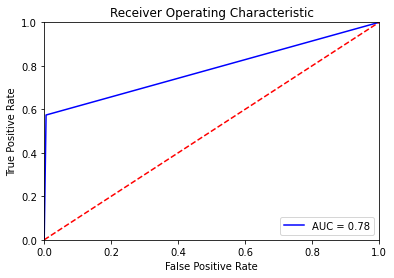

In [13]:

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix 
 [[2317   13]
 [  49   66]]
Confusion Matrix 
 [[2317   49]
 [  13   66]]

Recall TP/TP+FN =  0.5739130434782609


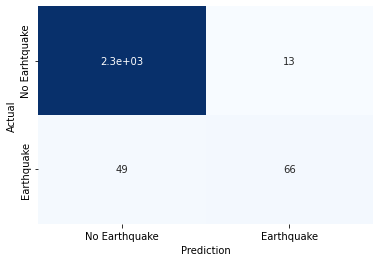

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred_ABC))
print('Confusion Matrix \n',confusion_matrix(pred_ABC,y_test))
confusion_matrix= confusion_matrix(y_test,pred_ABC)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'], 
                 cbar=False, cmap='Blues')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
dtc=recall_score(y_test,pred_ABC)
print("\nRecall TP/TP+FN = ",dtc)

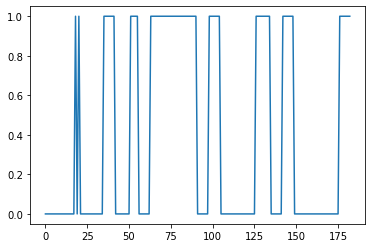

In [15]:
pred_ABC=grid_search_ABC.predict(df_predict[features])
plt.plot(pred_ABC)
plt.show()

In [16]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred_ABC
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='days')

live_set

,date,place,latitude,longitude,quake
0,2022-11-25,Papua New Guinea,-5.524528,149.714707,1.0
1,2022-11-27,Papua New Guinea,-5.524528,149.714707,1.0
2,2022-11-28,Montana,44.863002,-111.066538,0.0
3,2022-11-28,Papua New Guinea,-5.524528,149.714707,1.0
4,2022-11-28,Tonga,-18.591112,-174.017210,1.0
...,...,...,...,...,...
87,2022-12-07,Puerto Rico,18.114459,-66.833591,0.0
88,2022-12-07,Russia,52.017591,130.222957,1.0
89,2022-12-07,Texas,31.575240,-103.698497,0.0
90,2022-12-07,U.S. Virgin Islands,19.030958,-64.815751,1.0


In [17]:

# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

'2022-12-03'

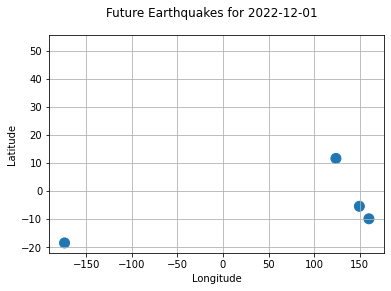

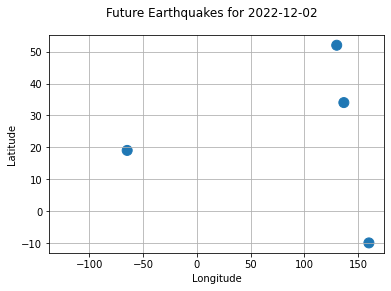

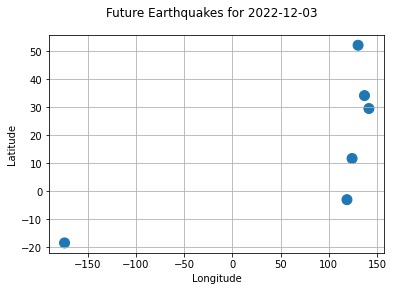

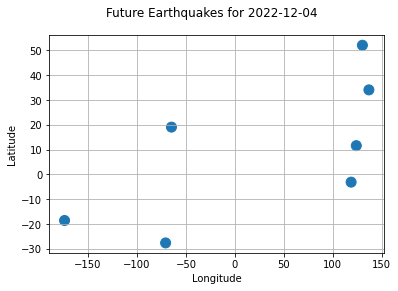

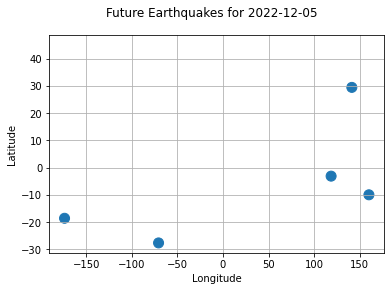

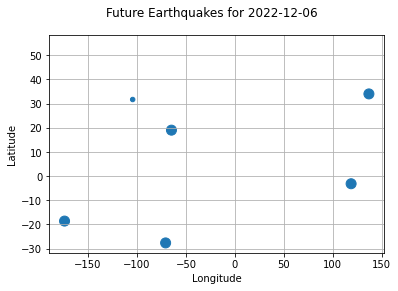

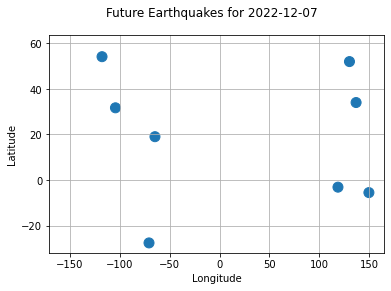

In [18]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()


In [19]:
live_set.to_csv('dt_live_dataset.csv',index=False)

### Random Forest Classifier

In [20]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [21]:
pred=CV_rfc.predict(X_test)

0.8113267400634446
AUC: 0.8113


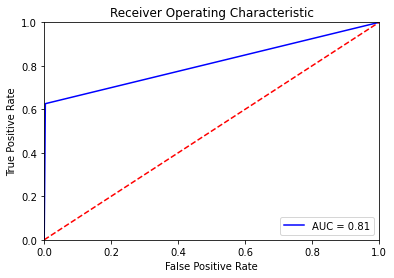

In [22]:
print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Confusion Matrix 
 [[2322    8]
 [  43   72]]
Confusion Matrix 
 [[2322   43]
 [   8   72]]

Recall 'TP/TP+FN' =  0.6260869565217392


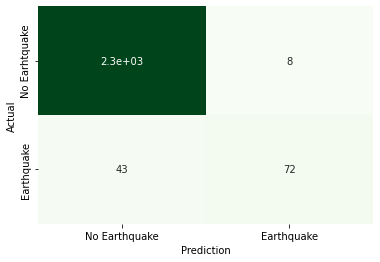

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred))
print('Confusion Matrix \n',confusion_matrix(pred,y_test))
confusion_matrix= confusion_matrix(y_test,pred)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='Greens')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
rfc=recall_score(y_test,pred)
print("\nRecall 'TP/TP+FN' = ", rfc)

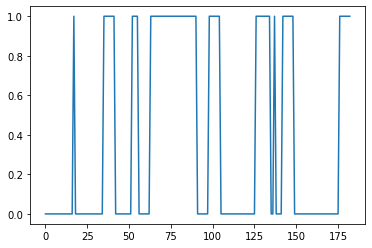

In [24]:
pred=CV_rfc.predict(df_predict[features])
plt.plot(pred)
plt.show()

In [25]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')
live_set.tail()

,date,place,latitude,longitude,quake
87,2022-12-07,Puerto Rico,18.114459,-66.833591,0.166667
88,2022-12-07,Russia,52.017591,130.222957,1.000000
89,2022-12-07,Texas,31.575240,-103.698497,0.000000
90,2022-12-07,U.S. Virgin Islands,19.030958,-64.815751,1.000000
91,2022-12-07,Utah,40.225939,-112.244823,0.000000


In [26]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

'2022-12-03'

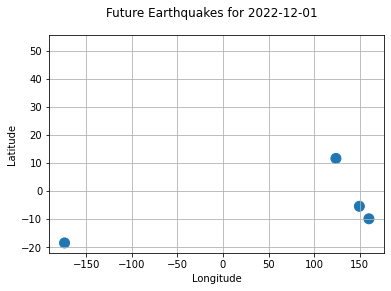

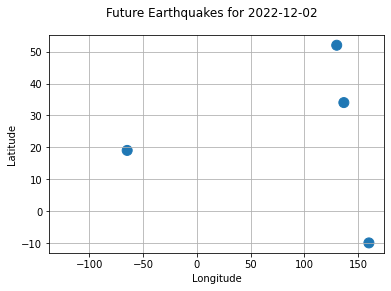

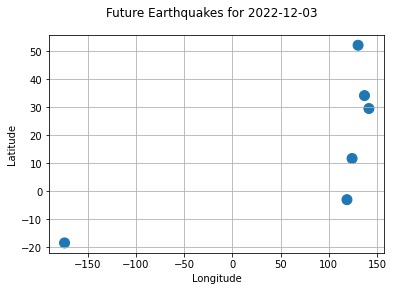

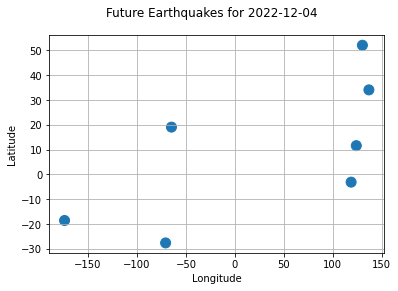

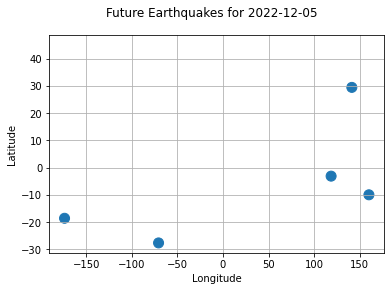

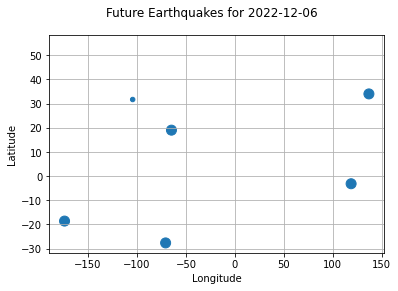

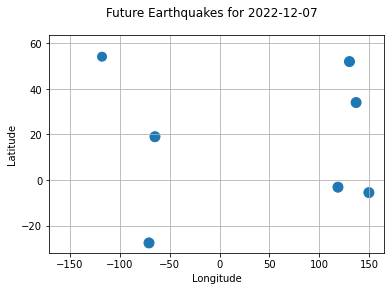

In [27]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()


In [28]:
live_set.to_csv('rfc_live_dataset.csv',index=False)

### XGBoost Algorithm

In [29]:
from xgboost import XGBClassifier
import xgboost as xgb

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations    
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)


[12:02:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [30]:
ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int)  

0.9875387199104311
AUC: 0.9875


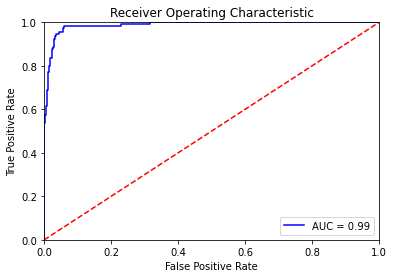

In [31]:

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Confusion Matrix 
 [[2315   15]
 [  44   71]]
Confusion Matrix 
 [[2315   44]
 [  15   71]]

Recall 'TP/TP+FN' =  0.6173913043478261


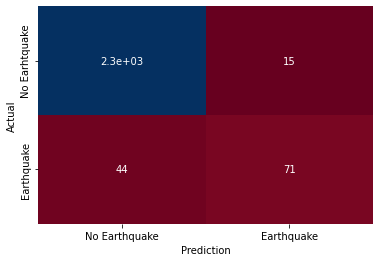

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,ypred_bst))
print('Confusion Matrix \n',confusion_matrix(ypred_bst,y_test))
confusion_matrix= confusion_matrix(y_test,ypred_bst)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='RdBu')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
xgbc=recall_score(y_test,ypred_bst)
print("\nRecall 'TP/TP+FN' = ", xgbc)

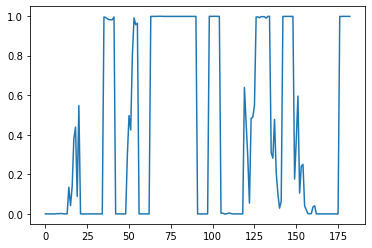

In [33]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

In [34]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
87,2022-12-07,Puerto Rico,18.114459,-66.833591,0.193945
88,2022-12-07,Russia,52.017591,130.222957,0.997667
89,2022-12-07,Texas,31.575240,-103.698497,0.518489
90,2022-12-07,U.S. Virgin Islands,19.030958,-64.815751,0.992225
91,2022-12-07,Utah,40.225939,-112.244823,0.000063


In [35]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

'2022-12-03'

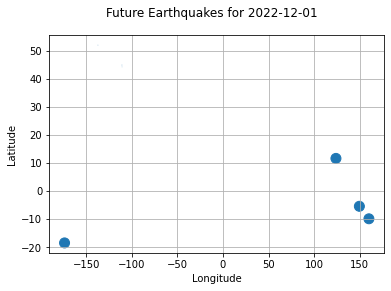

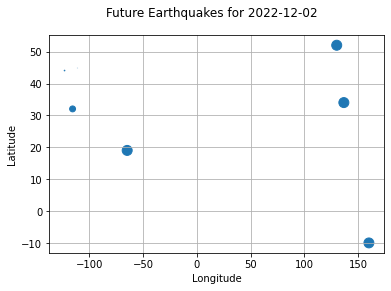

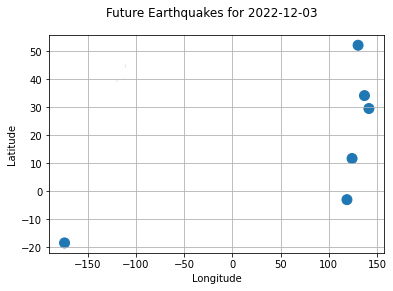

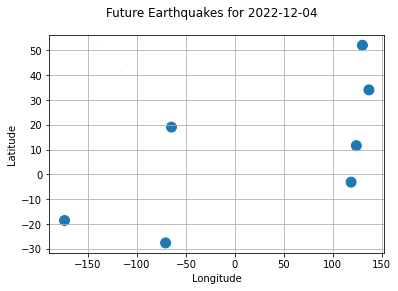

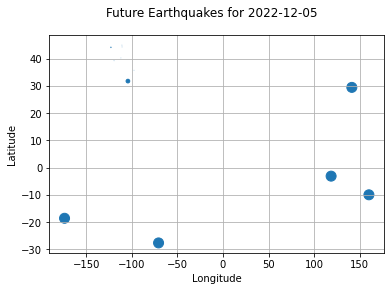

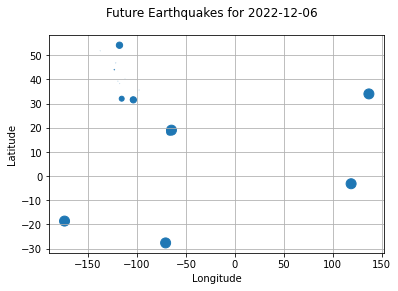

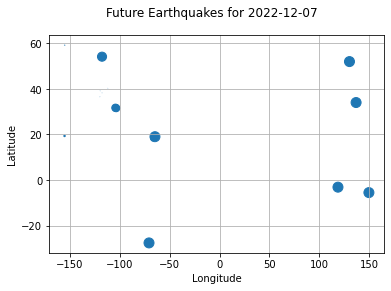

In [36]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

In [37]:
live_set.to_csv('xgb_live_dataset.csv',index=False)

### Multi-Layer Precepton

In [38]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# Input layer
model.add(Dense(32, activation='relu', input_dim=len(features)))
# Hidden Layer
model.add(Dense(16, activation='relu'))
# Output Layer
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [39]:
#Train the model
model.fit(X_train,y_train,epochs=200,verbose=False);

In [40]:
pred_mlp=(model.predict(X_test) > 0.5).astype("int32")

ROC_AUC_Score:  0.7726254898301922
AUC:  0.7726


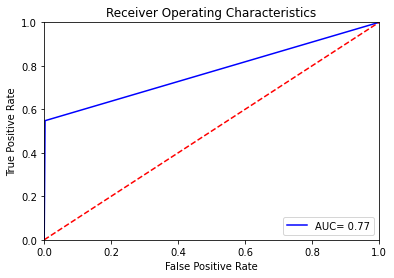

In [41]:
print("ROC_AUC_Score: ",roc_auc_score(y_test,pred_mlp))
fpr,tpr,_= roc_curve(y_test,pred_mlp)
roc_auc=auc(fpr,tpr)
print('AUC: ',np.round(roc_auc,4))

plt.title('Receiver Operating Characteristics')
plt.plot(fpr,tpr,'b',label='AUC= %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix 
 [[2324    6]
 [  52   63]]
Confusion Matrix 
 [[2324   52]
 [   6   63]]

Recall TP/TP+FN =  0.5478260869565217


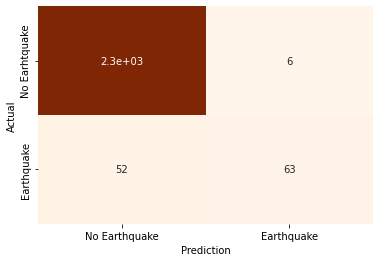

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred_mlp))
print('Confusion Matrix \n',confusion_matrix(pred_mlp,y_test))
confusion_matrix= confusion_matrix(y_test,pred_mlp)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='Oranges')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
mlpc=recall_score(y_test,pred_mlp)
print("\nRecall TP/TP+FN = ",mlpc)

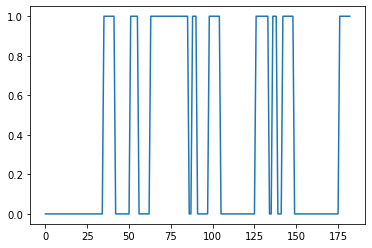

In [43]:
pred_mlp=(model.predict(df_predict[features]) > 0.5).astype("int32")
plt.plot(pred_mlp)
plt.show()

In [44]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred_mlp
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT 
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
87,2022-12-07,Puerto Rico,18.114459,-66.833591,0.5
88,2022-12-07,Russia,52.017591,130.222957,1.0
89,2022-12-07,Texas,31.575240,-103.698497,0.0
90,2022-12-07,U.S. Virgin Islands,19.030958,-64.815751,1.0
91,2022-12-07,Utah,40.225939,-112.244823,0.0


In [45]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

'2022-12-03'

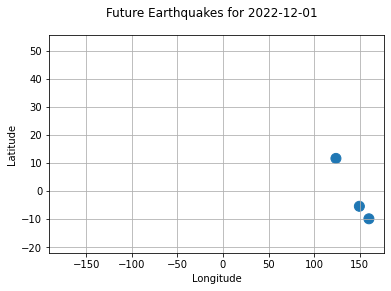

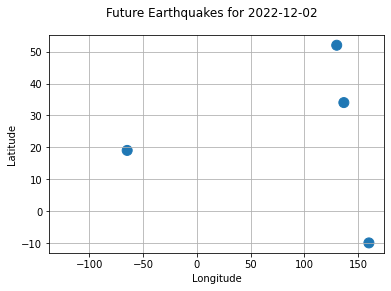

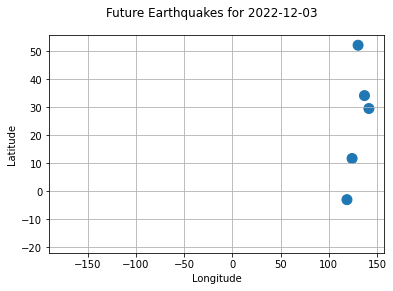

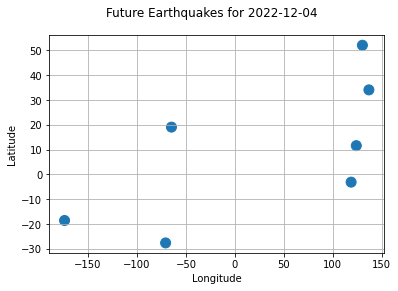

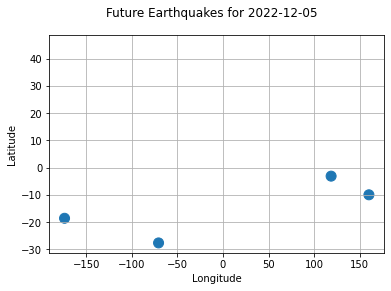

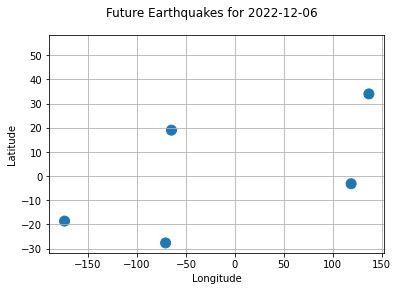

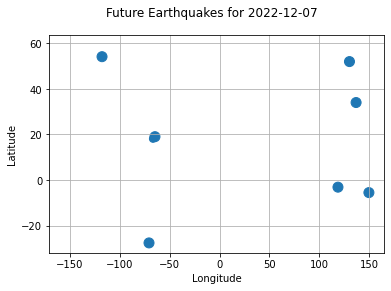

In [46]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()


In [47]:
live_set.to_csv('mlp_live_dataset.csv',index=False)

## Comparing models and find the best outcome

In [48]:

best_recall=max([dtc,rfc,xgbc,mlpc])
print("Recall (Sensitivity): ",best_recall)

Recall (Sensitivity):  0.6260869565217392


In [49]:
import datetime as dt
def live_prediction(x):
    if x== dtc:
        pred=grid_search_ABC.predict(df_predict[features])
    elif x==rfc:
        pred=CV_rfc.predict(df_predict[features])
    elif x==xgbc:
        dlive = xgb.DMatrix(df_predict[features]) #, label=[])
        pred = bst.predict(dlive)
    elif x==mlpc:
        pred=(model.predict(df_predict[features]) > 0.5).astype("int32")
    plt.plot(pred)
    plt.show()
    
    live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
    live_set.loc[:,'quake'] = pred
    # aggregate down dups
    live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

    # increment date to include DAYS_OUT_TO_PREDICT
    live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
    live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

    live_set.tail()
    
    # convert date to proper format for prediction
    days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
    days.sort()

    # Predict NaN outcome value in earthquake for next day 1.
    predict_day=days[2]
    predict_day
    
    # place, date, lat and long with earthquake probability for next 7 days
    for i in range(0,7):
        live_set_tmp = live_set[live_set['date'] == days[i]]
        plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
        plt.suptitle('Future Earthquakes for ' + days[i])
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid()
        plt.show()
    
    live_set.to_csv('best_recall_live_dataset.csv',index=False)

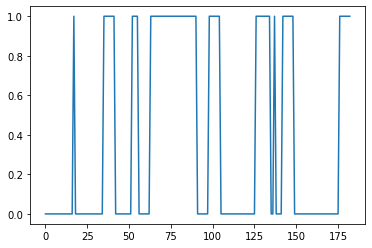

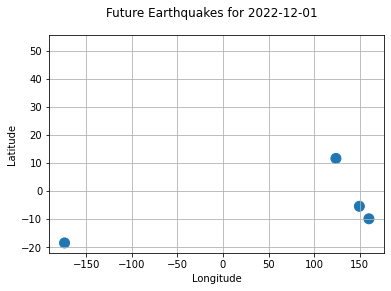

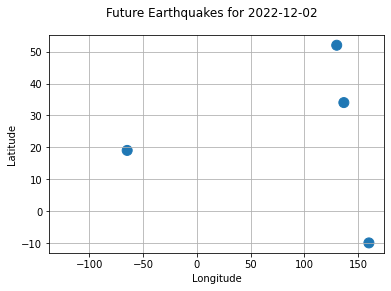

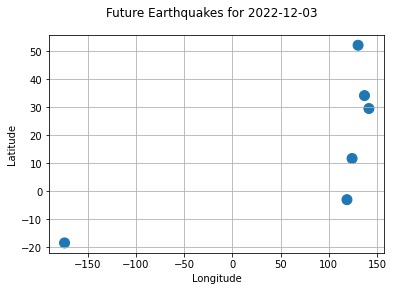

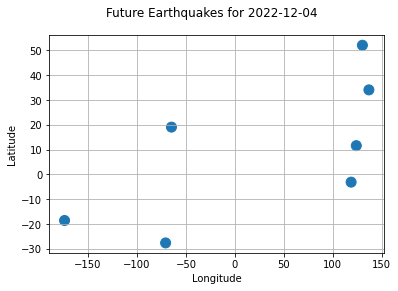

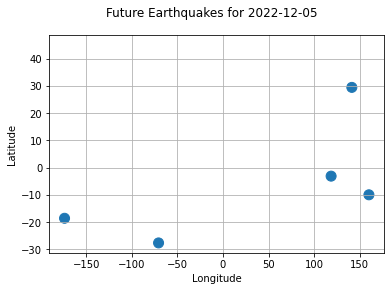

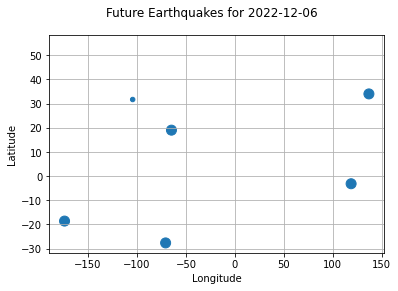

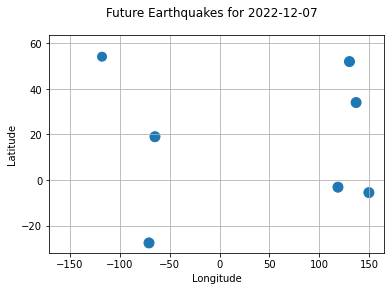

In [50]:
live_prediction(best_recall)